# Import libraries

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import tensorflow as tf

In [4]:
from sklearn. model_selection import train_test_split

In [58]:
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
import itertools

In [7]:
import random

In [8]:
import matplotlib.pyplot as plt

In [9]:
import matplotlib.cm as cm

In [10]:
import cv2

In [11]:
import seaborn as sns

In [12]:
from tensorflow import keras

In [13]:
from tensorflow.keras import layers, models

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [15]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [16]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [17]:
from tensorflow.keras import Model

In [18]:
from tensorflow.keras.layers.experimental import preprocessing

In [19]:
from tensorflow.keras.optimizers import Adam

In [20]:
from pathlib import Path
import os.path

In [21]:
from sklearn.metrics import confusion_matrix

# import Helper Function

In [22]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-24 22:32:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.4’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.01s   

2024-02-24 22:32:31 (932 KB/s) - ‘helper_functions.py.4’ saved [10246/10246]



In [23]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, pred_and_plot, compare_historys, walk_through_dir

In [24]:
def seed_everything(seed=42):
    tf.random.set_seed(seed)
    
    np.random.seed(seed)
    
    session_conf = tf.compat.v1.config.proto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1)
    
    tf.compat.v1.set_random_seed(seed)
    
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    
    seed_everyhting()

# Data import and organization

In [25]:
BATCH_SIZE = 32 # only pass through 32 samples neural network 
TARGET_SIZE = (224,224) # Resize all images to 224,224

In [26]:
dataset= "/Users/luis/Documents/STEMFairCoral/images"
walk_through_dir(dataset) #the imput images

There are 3 directories and 2 images in '/Users/luis/Documents/STEMFairCoral/images'.
There are 0 directories and 55 images in '/Users/luis/Documents/STEMFairCoral/images/healthy'.
There are 0 directories and 51 images in '/Users/luis/Documents/STEMFairCoral/images/bleached'.
There are 0 directories and 1 images in '/Users/luis/Documents/STEMFairCoral/images/.ipynb_checkpoints'.


def convert_path_to_df(dataset):
    image_dir = Path(dataset)
    #for each file it is creating a list to lable - any file with the same extentsion that has the ending. .jpeg, pull it out
    #Anything in the directory
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.webp')) + list(image_dir.glob(r'**/*.avif'))
    lables = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))     #the function for splitting up and the full file path
                                                                                                                                  
    #IMAGES that end in jpeg or jpg are added
    filepaths = pd.Series(filepaths, name="Filepath").astype(str)
    labels = pd.Series(labels, name="Label")
                                                  
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df
                                                                                                                                  
image_df= convert_path_to_df(dataset)
  
                                                                                                                                
#output of what we do is always on the left and the instructions are on the right
#create a function to give lables - specifies the path to find the data set - 
#data set is the variable to descrive the path - you can assign a value name instead of typing out over and over - Path = location

In [27]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [28]:
dataset

'/Users/luis/Documents/STEMFairCoral/images'

In [29]:
label_counts = image_df['Label']. value_counts()

In [30]:
image_df

Filepath     Label
0   /Users/luis/Documents/STEMFairCoral/images/hea...   healthy
1   /Users/luis/Documents/STEMFairCoral/images/hea...   healthy
2   /Users/luis/Documents/STEMFairCoral/images/hea...   healthy
3   /Users/luis/Documents/STEMFairCoral/images/hea...   healthy
4   /Users/luis/Documents/STEMFairCoral/images/hea...   healthy
..                                                ...       ...
93  /Users/luis/Documents/STEMFairCoral/images/ble...  bleached
94  /Users/luis/Documents/STEMFairCoral/images/ble...  bleached
95  /Users/luis/Documents/STEMFairCoral/images/ble...  bleached
96  /Users/luis/Documents/STEMFairCoral/images/ble...  bleached
97  /Users/luis/Documents/STEMFairCoral/images/ble...  bleached

[98 rows x 2 columns]

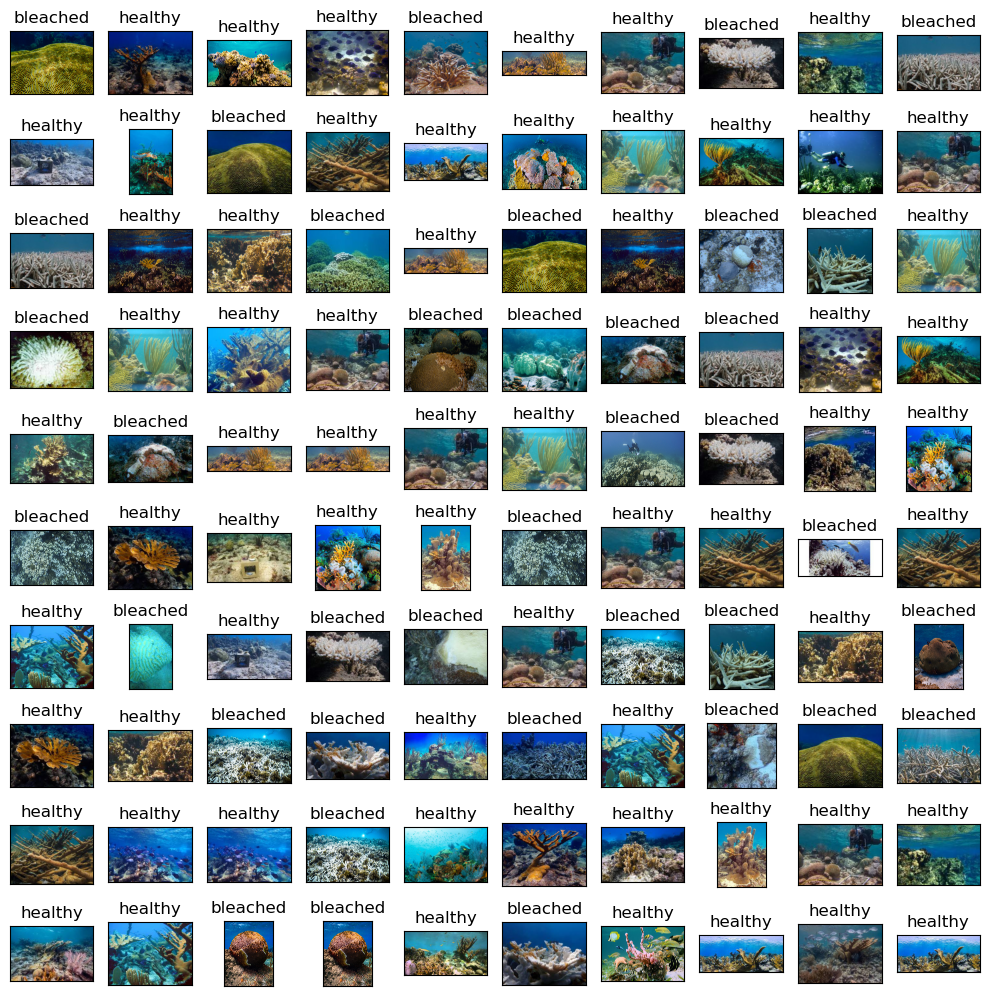

In [31]:
random_index = np.random.randint(0, len(image_df), 100)
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]], color="black")
plt.tight_layout()
plt.show()                  

# data pre processing 

In [32]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True,random_state=42)

In [33]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
)

In [46]:
# split the data into two caterogries
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col='Filepath',
    y_col='Label',
    target_size = TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)
    
val_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col='Filepath',
    y_col='Label',
    target_size = TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = train_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col='Filepath',
    y_col='Label',
    target_size = TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 63 validated image filenames belonging to 2 classes.
Found 15 validated image filenames belonging to 2 classes.
Found 20 validated image filenames belonging to 2 classes.


# data augmentation 
#goal = increase the dicweristy training set by adding random transformative of images

In [47]:
augment = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    
    
])

# Training

In [48]:
# loading model VGG19
pretrained_model = tf.keras.applications.vgg19.VGG19(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
    pooling="max"
)

pretrained_model.trainable = False

In [49]:
checkpoint_path = "corals_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path, 
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True                               

)

early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor=0.2, patience=3, min_lr=1e-10)

In [50]:
inputs = pretrained_model.input
x = augment(inputs)
x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256,activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

outputs = Dense(2, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=Adam(0.001),
    loss="categorical_crossentropy",
    metrics=['accuracy']
    
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data = val_images,
    validation_steps=len(val_images),
    epochs=4,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("train_logs",
                                    "corals_classification"),
        checkpoint_callback,
        reduce_lr
        
    ]
   
)

Saving TensorBoard log files to: train_logs/corals_classification/20240224-225101
Epoch 1/4
2/2 [==============================] - 40s 24s/step - loss: 0.9826 - accuracy: 0.5079 - val_loss: 3.5418 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/4
2/2 [==============================] - 43s 25s/step - loss: 0.9809 - accuracy: 0.6190 - val_loss: 2.7882 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 3/4
2/2 [==============================] - 31s 17s/step - loss: 0.7250 - accuracy: 0.6984 - val_loss: 2.4903 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 4/4
2/2 [==============================] - 30s 18s/step - loss: 0.4088 - accuracy: 0.8095 - val_loss: 2.4582 - val_accuracy: 0.6000 - lr: 0.0010


In [51]:
result = model.evaluate(test_images, verbose=0)

print(" Test Loss: {:.5f}".format(result[0]))
print("Test Accuracy: {:.2f}%".format(result[1]* 100))

 Test Loss: 1.34496
Test Accuracy: 70.00%


In [52]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())

pred = [labels[k] for k in pred]

1/1 [==============================] - 7s 7s/step


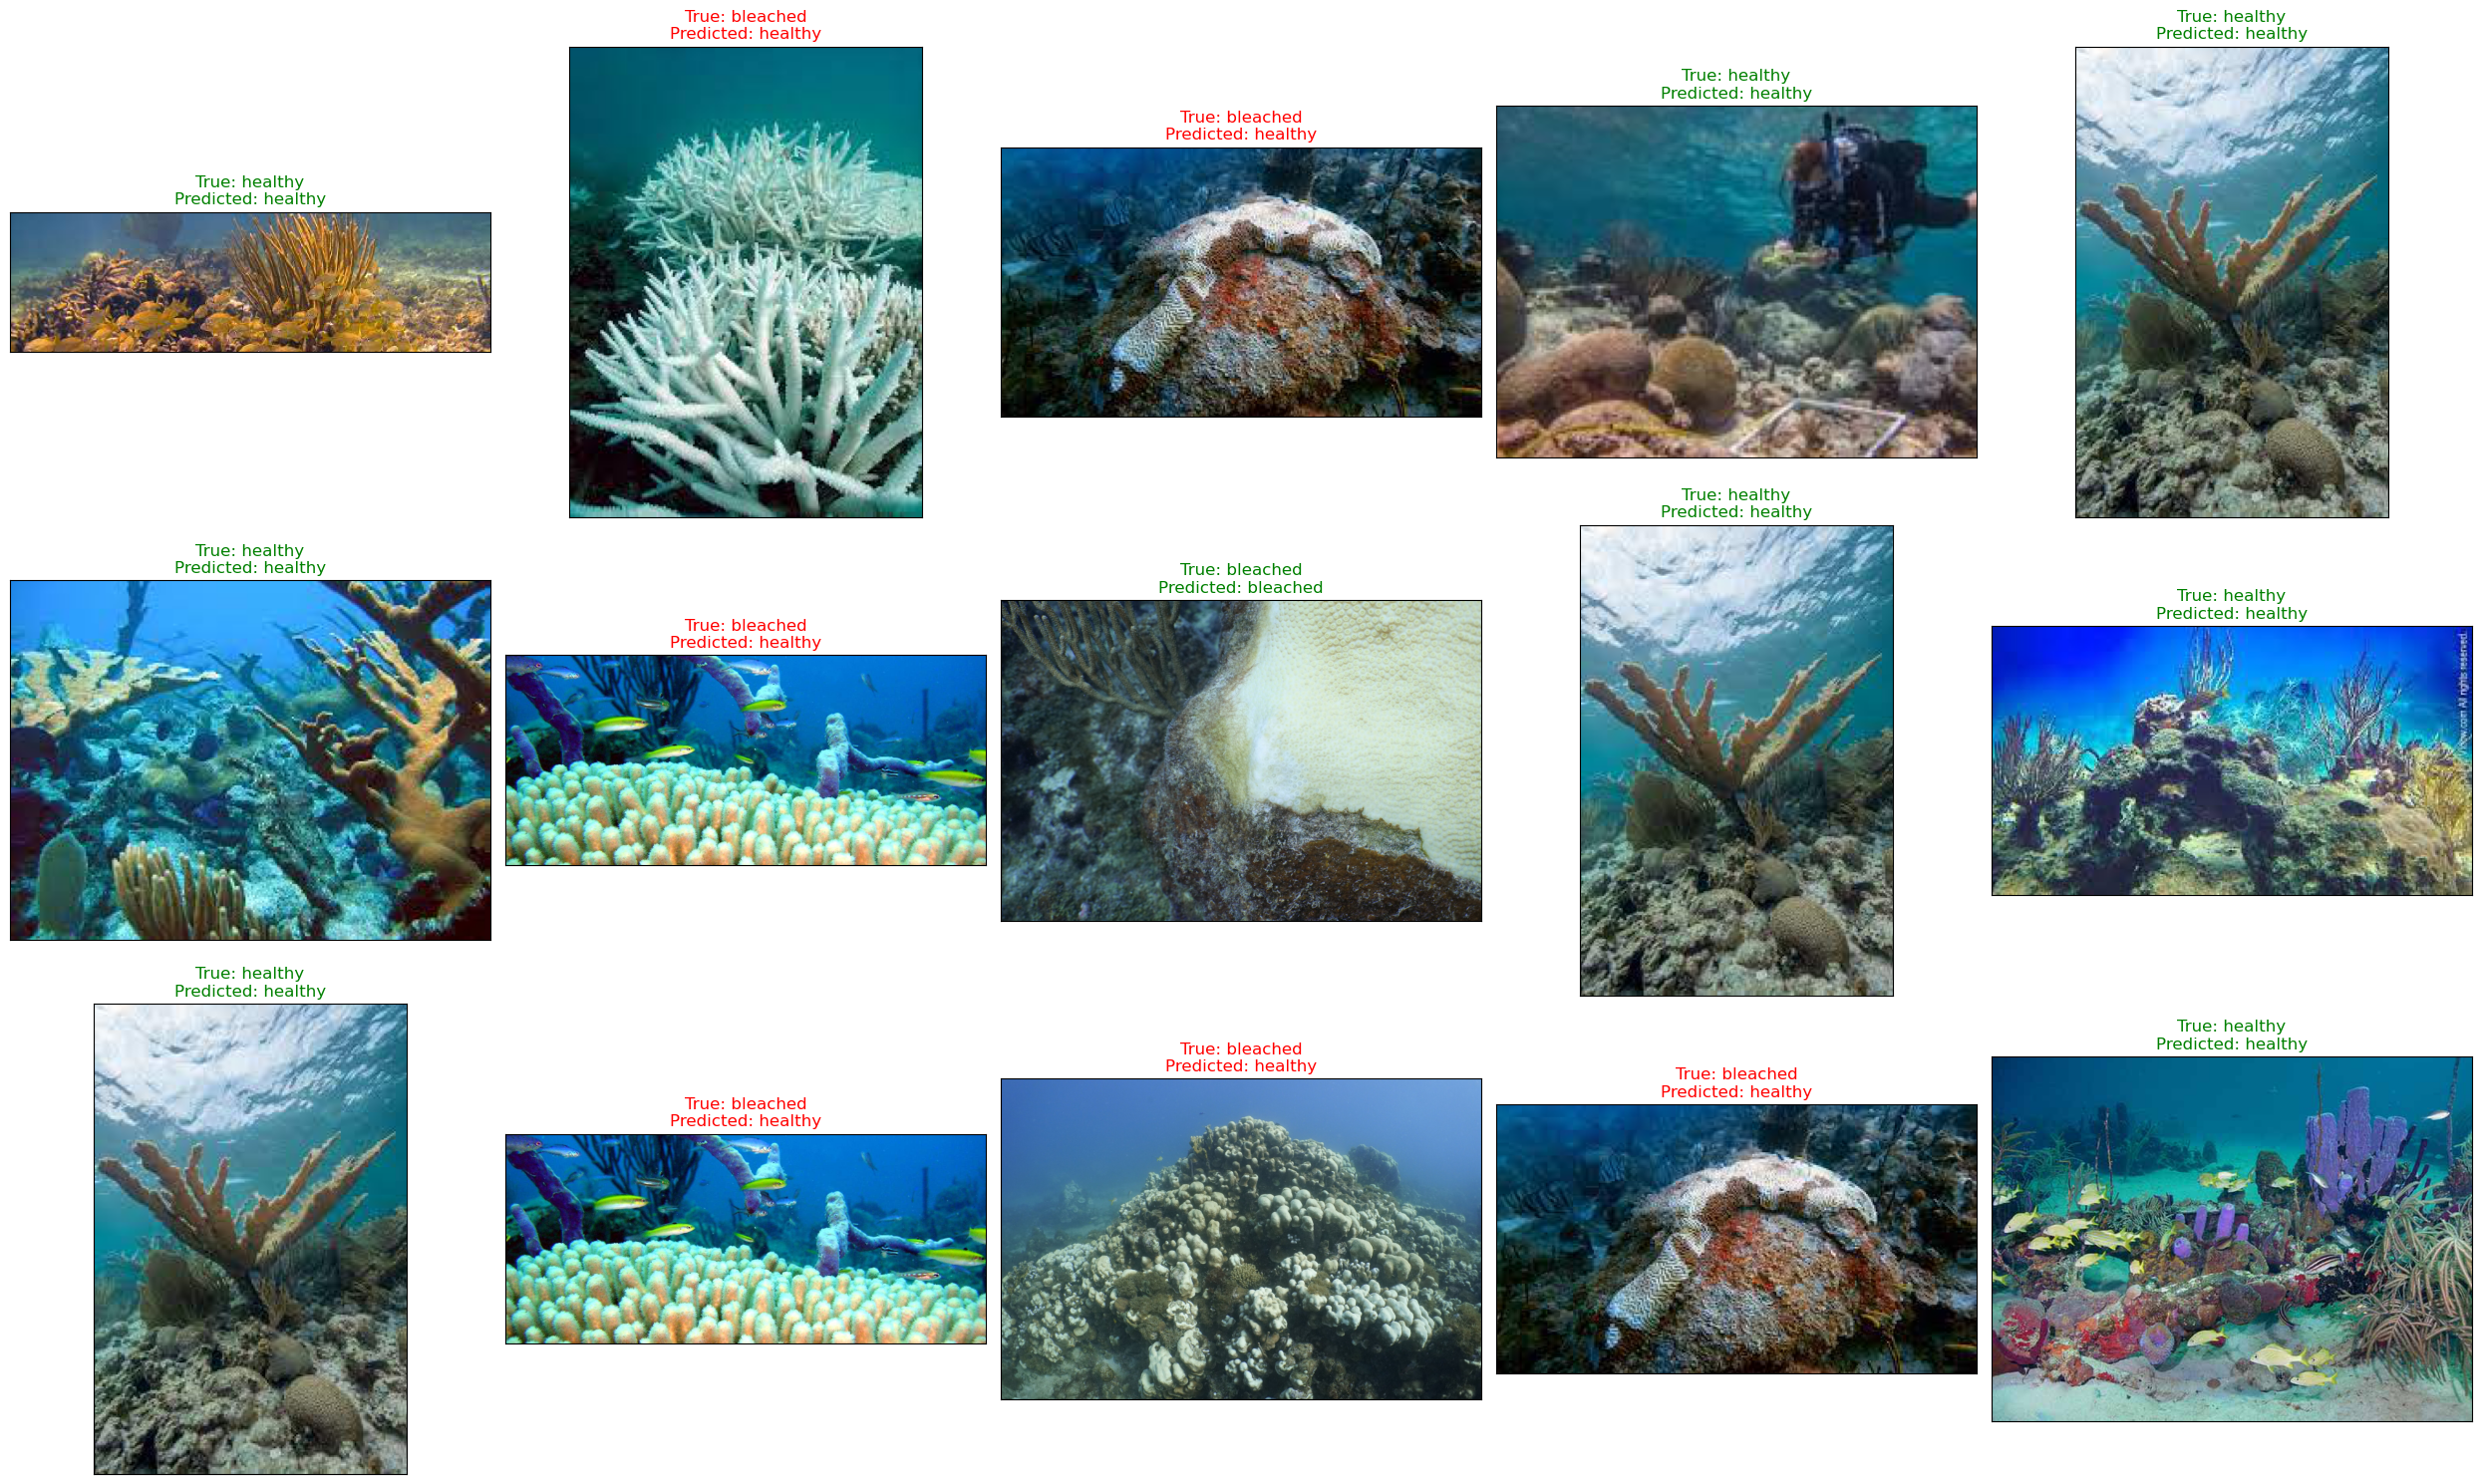

In [53]:
random_index = np.random.randint(0,len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25,15),
                         subplot_kw={'xticks': [], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

plt.show
plt.tight_layout()

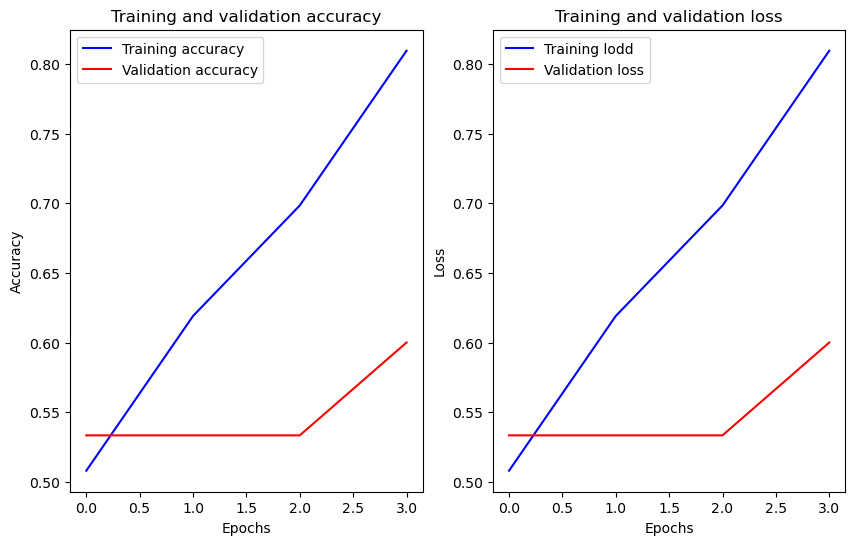

In [54]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))


ax1.plot(epochs, accuracy, 'b', label = "Training accuracy")
ax1.plot(epochs, val_accuracy, 'r', label = "Validation accuracy")
ax1.set_title("Training and validation accuracy")
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Accuracy")
ax1.legend()

ax2.plot(epochs, accuracy, 'b', label = "Training lodd")
ax2.plot(epochs, val_accuracy, 'r', label = "Validation loss")
ax2.set_title("Training and validation loss")
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Loss")
ax2.legend()

# Confusion Matrics


In [69]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
report

{'bleached': {'precision': 1.0,
  'recall': 0.25,
  'f1-score': 0.4,
  'support': 8.0},
 'healthy': {'precision': 0.6666666666666666,
  'recall': 1.0,
  'f1-score': 0.8,
  'support': 12.0},
 'accuracy': 0.7,
 'macro avg': {'precision': 0.8333333333333333,
  'recall': 0.625,
  'f1-score': 0.6000000000000001,
  'support': 20.0},
 'weighted avg': {'precision': 0.8,
  'recall': 0.7,
  'f1-score': 0.64,
  'support': 20.0}}

In [67]:
from  sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [72]:
test = confusion_matrix(y_test, pred, labels=list(labels.values()))

In [73]:
disp = ConfusionMatrixDisplay(confusion_matrix=test,
                              display_labels=list(labels.values()))

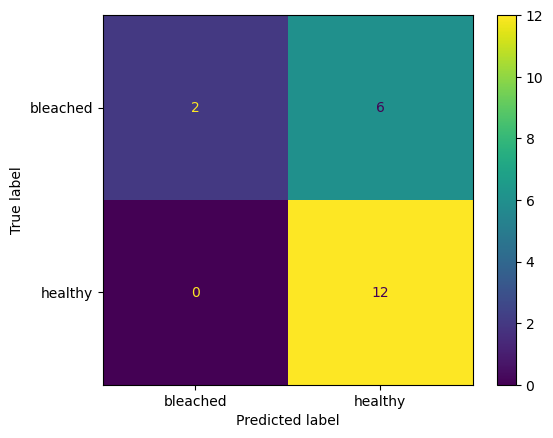

In [74]:
disp.plot()